In [1]:
#导入与设备
import time
import math
import os
import sys
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch: 2.7.1+cu118
Device: cuda


In [2]:
#通用工具函数 Fixes the source of randomness to ensure experiment reproducibility; automatically prioritizes using the GPU.
def seed_everything(seed: int = 42):
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)


def count_params(model: nn.Module) -> Tuple[int, int]:
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


@torch.no_grad()
def evaluate_acc(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total


def run_one_epoch(loader: DataLoader,
                  model: nn.Module,
                  criterion: nn.Module,
                  optimizer: optim.Optimizer = None,
                  train: bool = False,
                  device: torch.device = torch.device("cpu")) -> Tuple[float, float]:
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return epoch_loss / total, correct / total

In [3]:
#定义CNN(无 BatchNorm，2 层卷积)
class SimpleCNN(nn.Module):
    """
    2 个卷积块（Conv → ReLU → MaxPool），无 BatchNorm。
    使用动态推断来确定全连接层的输入维度，适配不同输入尺寸与通道数。
    """
    def __init__(self, in_channels=1, num_classes=10, img_size=28):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),  # -> 32 x H x W
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # -> 32 x H/2 x W/2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),          # -> 64 x H/2 x W/2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # -> 64 x H/4 x W/4
        )

        # 动态计算扁平维度
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_size, img_size)
            flat_dim = self.features(dummy).view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
#数据加载（MNIST 与 CIFAR10）
data_root = "./data"

# MNIST: 灰度 1x28x28
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_full = datasets.MNIST(root=data_root, train=True,  download=True, transform=mnist_transform)
mnist_test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=mnist_transform)

mnist_val_ratio   = 0.1
mnist_val_size    = int(len(mnist_train_full) * mnist_val_ratio)
mnist_train_size  = len(mnist_train_full) - mnist_val_size
mnist_train_ds, mnist_val_ds = random_split(
    mnist_train_full, [mnist_train_size, mnist_val_size],
    generator=torch.Generator().manual_seed(42)
)

mnist_train_loader = DataLoader(mnist_train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=False)
mnist_val_loader   = DataLoader(mnist_val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=False)
mnist_test_loader  = DataLoader(mnist_test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=False)

print(f"MNIST -> Train: {len(mnist_train_ds)}, Val: {len(mnist_val_ds)}, Test: {len(mnist_test_ds)}")

# CIFAR10: RGB 3x32x32
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

cifar_train_full = datasets.CIFAR10(root=data_root, train=True,  download=True, transform=cifar_transform)
cifar_test_ds    = datasets.CIFAR10(root=data_root, train=False, download=True, transform=cifar_transform)

cifar_val_ratio  = 0.1
cifar_val_size   = int(len(cifar_train_full) * cifar_val_ratio)
cifar_train_size = len(cifar_train_full) - cifar_val_size
cifar_train_ds, cifar_val_ds = random_split(
    cifar_train_full, [cifar_train_size, cifar_val_size],
    generator=torch.Generator().manual_seed(42)
)

cifar_train_loader = DataLoader(cifar_train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=False)
cifar_val_loader   = DataLoader(cifar_val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=False)
cifar_test_loader  = DataLoader(cifar_test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=False)

print(f"CIFAR10 -> Train: {len(cifar_train_ds)}, Val: {len(cifar_val_ds)}, Test: {len(cifar_test_ds)}")

MNIST -> Train: 54000, Val: 6000, Test: 10000
CIFAR10 -> Train: 45000, Val: 5000, Test: 10000


In [5]:
#训练配置与例行函数（可复用）
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int = 15,
                lr: float = 1e-3,
                weight_decay: float = 5e-4,
                ckpt_path: str = "best.pt",
                use_plateau: bool = True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, min_lr=1e-5) if use_plateau else None

    best_val_loss = float("inf")
    patience, early_patience = 0, 6  # 可按需调整
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lrs": [], "time": []}

    for ep in range(1, epochs + 1):
        ep_start = time.time()

        tr_loss, tr_acc = run_one_epoch(train_loader, model, criterion, optimizer, train=True, device=device)
        val_loss, val_acc = run_one_epoch(val_loader,   model, criterion, optimizer=None, train=False, device=device)

        if scheduler is not None:
            scheduler.step(val_loss)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lrs"].append(optimizer.param_groups[0]["lr"])
        history["time"].append(time.time() - ep_start)

        print(f"[{os.path.basename(ckpt_path)}] Epoch {ep:02d}/{epochs} | "
              f"Time {history['time'][-1]:.1f}s | "
              f"Train {tr_loss:.4f}/{tr_acc:.4f} | "
              f"Val {val_loss:.4f}/{val_acc:.4f} | "
              f"LR {optimizer.param_groups[0]['lr']:.1e}")

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            patience = 0
            torch.save({"model": model.state_dict()}, ckpt_path)
        else:
            patience += 1
            if patience >= early_patience:
                print("Early stopping.")
                break

    # 加载最佳权重
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
    return history

In [6]:
#训练并评估 CNN（MNIST）
mnist_cnn = SimpleCNN(in_channels=1, num_classes=10, img_size=28).to(device)
mnist_cnn_params = count_params(mnist_cnn)
print("MNIST-CNN params:", f"total={mnist_cnn_params[0]:,}, trainable={mnist_cnn_params[1]:,}")

ckpt_mnist = "./mnist_cnn_best.pt"
_ = train_model(mnist_cnn, mnist_train_loader, mnist_val_loader, device,
                epochs=10, lr=1e-3, weight_decay=5e-4, ckpt_path=ckpt_mnist)

mnist_cnn_test_acc = evaluate_acc(mnist_cnn, mnist_test_loader, device)
print(f"MNIST-CNN Test Accuracy: {mnist_cnn_test_acc:.4f}")

MNIST-CNN params: total=50,186, trainable=50,186
[mnist_cnn_best.pt] Epoch 01/10 | Time 6.2s | Train 0.1973/0.9412 | Val 0.0741/0.9768 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 02/10 | Time 4.6s | Train 0.0550/0.9831 | Val 0.0721/0.9785 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 03/10 | Time 4.7s | Train 0.0409/0.9872 | Val 0.0538/0.9850 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 04/10 | Time 4.8s | Train 0.0349/0.9894 | Val 0.0532/0.9857 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 05/10 | Time 4.6s | Train 0.0287/0.9912 | Val 0.0470/0.9858 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 06/10 | Time 4.9s | Train 0.0252/0.9924 | Val 0.0496/0.9855 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 07/10 | Time 4.9s | Train 0.0231/0.9927 | Val 0.0508/0.9847 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 08/10 | Time 5.0s | Train 0.0205/0.9938 | Val 0.0438/0.9877 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 09/10 | Time 4.9s | Train 0.0205/0.9936 | Val 0.0447/0.9860 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 10/10 | Time 4.8s | Train 0.0190/0

In [7]:
#训练并评估 CNN（CIFAR10）
cifar_cnn = SimpleCNN(in_channels=3, num_classes=10, img_size=32).to(device)
cifar_cnn_params = count_params(cifar_cnn)
print("CIFAR10-CNN params:", f"total={cifar_cnn_params[0]:,}, trainable={cifar_cnn_params[1]:,}")

ckpt_cifar = "./cifar10_cnn_best.pt"
_ = train_model(cifar_cnn, cifar_train_loader, cifar_val_loader, device,
                epochs=25, lr=1e-3, weight_decay=5e-4, ckpt_path=ckpt_cifar)

cifar_cnn_test_acc = evaluate_acc(cifar_cnn, cifar_test_loader, device)
print(f"CIFAR10-CNN Test Accuracy: {cifar_cnn_test_acc:.4f}")

CIFAR10-CNN params: total=60,362, trainable=60,362
[cifar10_cnn_best.pt] Epoch 01/25 | Time 5.0s | Train 1.3937/0.5074 | Val 1.1438/0.5994 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 02/25 | Time 4.9s | Train 1.0327/0.6407 | Val 0.9781/0.6652 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 03/25 | Time 4.7s | Train 0.9011/0.6898 | Val 0.9166/0.6830 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 04/25 | Time 4.8s | Train 0.8232/0.7172 | Val 0.9070/0.6832 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 05/25 | Time 5.0s | Train 0.7665/0.7365 | Val 0.8651/0.6944 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 06/25 | Time 5.0s | Train 0.7097/0.7571 | Val 0.8697/0.7064 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 07/25 | Time 5.0s | Train 0.6672/0.7715 | Val 0.8689/0.7016 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 08/25 | Time 4.7s | Train 0.6291/0.7847 | Val 0.8503/0.7046 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 09/25 | Time 4.6s | Train 0.5956/0.7940 | Val 0.8726/0.7104 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 10/25 | Time

In [8]:
# === 手动填写或替换为你之前记录的 MLP 结果 ===
mlp_mnist_acc = 0.9832   # TODO: 填入你的 MNIST-MLP 测试准确率
mlp_cifar_acc = 0.5618   # TODO: 填入你的 CIFAR10-MLP 测试准确率
mlp_mnist_params = 235146     # TODO: MNIST-MLP 的总参数量
mlp_cifar_params = 820874     # TODO: CIFAR10-MLP 的总参数量

# === CNN 结果（来自本 Notebook 训练）===
cnn_mnist_acc = mnist_cnn_test_acc
cnn_cifar_acc = cifar_cnn_test_acc
cnn_mnist_params = mnist_cnn_params[0]
cnn_cifar_params = cifar_cnn_params[0]

# 打印 Markdown 表格（不依赖外部库）
print("| Model | MNIST (acc, params) | CIFAR10 (acc, params) |")
print("|-------|----------------------|------------------------|")
print(f"| MLP   | {mlp_mnist_acc:.4f}, {mlp_mnist_params:,} | {mlp_cifar_acc:.4f}, {mlp_cifar_params:,} |")
print(f"| CNN   | {cnn_mnist_acc:.4f}, {cnn_mnist_params:,} | {cnn_cifar_acc:.4f}, {cnn_cifar_params:,} |")

| Model | MNIST (acc, params) | CIFAR10 (acc, params) |
|-------|----------------------|------------------------|
| MLP   | 0.9832, 235,146 | 0.5618, 820,874 |
| CNN   | 0.9900, 50,186 | 0.7215, 60,362 |


In [9]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    """
    history: dict，包含键 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(10, 4))

    # 子图1：Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 子图2：Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

[mnist_cnn_best.pt] Epoch 01/10 | Time 4.7s | Train 0.0221/0.9932 | Val 0.0454/0.9860 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 02/10 | Time 4.7s | Train 0.0194/0.9939 | Val 0.0461/0.9853 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 03/10 | Time 4.6s | Train 0.0172/0.9944 | Val 0.0446/0.9868 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 04/10 | Time 4.7s | Train 0.0167/0.9952 | Val 0.0489/0.9852 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 05/10 | Time 5.2s | Train 0.0165/0.9946 | Val 0.0463/0.9857 | LR 1.0e-03
[mnist_cnn_best.pt] Epoch 06/10 | Time 4.5s | Train 0.0151/0.9951 | Val 0.0477/0.9850 | LR 5.0e-04
[mnist_cnn_best.pt] Epoch 07/10 | Time 4.7s | Train 0.0095/0.9974 | Val 0.0407/0.9880 | LR 5.0e-04
[mnist_cnn_best.pt] Epoch 08/10 | Time 5.2s | Train 0.0082/0.9981 | Val 0.0374/0.9885 | LR 5.0e-04
[mnist_cnn_best.pt] Epoch 09/10 | Time 4.9s | Train 0.0084/0.9980 | Val 0.0419/0.9863 | LR 5.0e-04
[mnist_cnn_best.pt] Epoch 10/10 | Time 4.8s | Train 0.0084/0.9981 | Val 0.0424/0.9870 | LR 5.0e-04


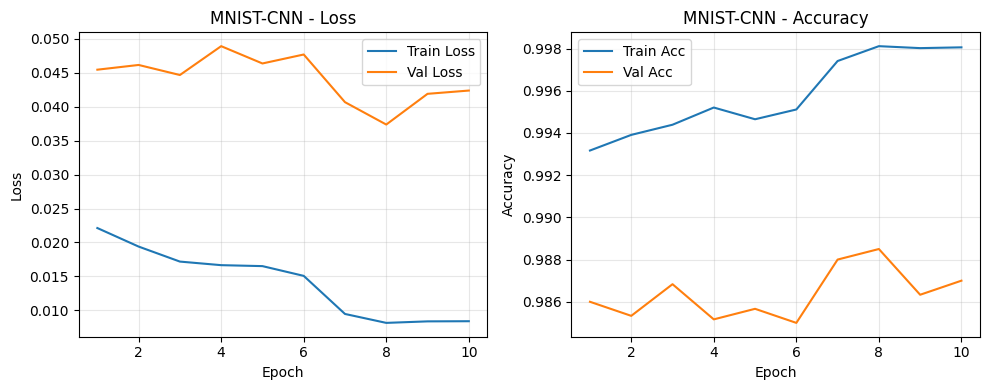

[cifar10_cnn_best.pt] Epoch 01/25 | Time 5.0s | Train 0.5153/0.8220 | Val 0.8640/0.7118 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 02/25 | Time 4.8s | Train 0.4853/0.8336 | Val 0.8465/0.7126 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 03/25 | Time 4.7s | Train 0.4685/0.8376 | Val 0.9046/0.7120 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 04/25 | Time 4.8s | Train 0.4448/0.8445 | Val 0.9398/0.7116 | LR 1.0e-03
[cifar10_cnn_best.pt] Epoch 05/25 | Time 5.0s | Train 0.4256/0.8530 | Val 0.9058/0.7140 | LR 5.0e-04
[cifar10_cnn_best.pt] Epoch 06/25 | Time 4.9s | Train 0.3489/0.8846 | Val 0.9267/0.7124 | LR 5.0e-04
[cifar10_cnn_best.pt] Epoch 07/25 | Time 4.8s | Train 0.3361/0.8896 | Val 0.9169/0.7190 | LR 5.0e-04
[cifar10_cnn_best.pt] Epoch 08/25 | Time 5.0s | Train 0.3236/0.8957 | Val 0.9350/0.7186 | LR 2.5e-04
Early stopping.


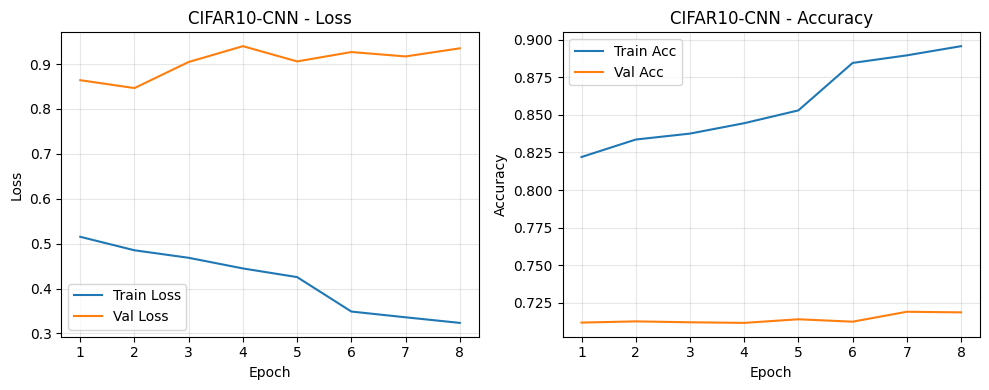

In [11]:
# MNIST-CNN
history_mnist_cnn = train_model(mnist_cnn, mnist_train_loader, mnist_val_loader, device,
                                epochs=10, lr=1e-3, weight_decay=5e-4, ckpt_path=ckpt_mnist)
plot_training_history(history_mnist_cnn, title="MNIST-CNN")

# CIFAR10-CNN
history_cifar_cnn = train_model(cifar_cnn, cifar_train_loader, cifar_val_loader, device,
                                epochs=25, lr=1e-3, weight_decay=5e-4, ckpt_path=ckpt_cifar)
plot_training_history(history_cifar_cnn, title="CIFAR10-CNN")